# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# We recommend to use tensorflow==1.14.0
print("TensorFlow Version {}".format(tf.__version__))

/home/hitarth/anaconda3/envs/cs566/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hitarth/anaconda3/envs/cs566/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hitarth/anaconda3/envs/cs566/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hitarth/anaconda3/envs/cs566/lib/python3

TensorFlow Version 1.14.0


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [2]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

In [3]:
from collections import Counter

Y_train_count = Counter(Y_train)
Y_val_count = Counter(Y_val)
Y_test_count = Counter(Y_test)

print(f'Y_train_count: {Y_train_count}')
print(f'Y_val_count: {Y_val_count}')
print(f'Y_test_count: {Y_test_count}')

Y_train_count: Counter({4: 4922, 2: 4921, 0: 4913, 5: 4902, 6: 4898, 9: 4895, 7: 4893, 3: 4888, 8: 4887, 1: 4881})
Y_val_count: Counter({1: 119, 8: 113, 3: 112, 7: 107, 9: 105, 6: 102, 5: 98, 0: 87, 2: 79, 4: 78})
Y_test_count: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


## Question 2-1 [10pt]

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits_v2'


Your model **should** achieve about 55% accuracy on test set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [4]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
    regularizer = tf.contrib.layers.l2_regularizer(scale = 0.00025)
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02), regularizer)
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    regularizer = tf.contrib.layers.l2_regularizer(scale = 0.00025)
#     return tf.contrib.layers.fully_connected(input, num_output, activation_fn = None, weights_regularizer = regularizer)
    
    W = tf.get_variable('w', [input.get_shape()[1], num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02), regularizer)
    b = tf.get_variable('b', [num_output], tf.float32, tf.constant_initializer(0.0))
    return tf.matmul(input, W) + b

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [5]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 100
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        self.step = tf.get_variable(name = 'step', dtype = tf.int32, initializer = 0)
        self.rate = tf.train.exponential_decay(5e-4, self.step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(self.rate).minimize(self.loss_op, global_step=self.step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        #############################################################################
        # TODO: Softmax cross entropy loss 'self.loss_op'                           #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels, logits, name='loss'))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
        plt.subplot(2,1,1)
        plt.title('Training loss vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.plot(losses, '-o')
        # Graph 2. X: iteration (training step), Y: training accuracy
        
        plt.subplot(2,1,2)
        plt.title('Training accuracy vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.plot(accuracies, '-o')
        
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
Instructions for updating:
Use keras.layers.flatten instead.
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 5.605, accuracy = 0.070
iteration (100): loss = 1.692, accuracy = 0.367
iteration (200): loss = 1.549, accuracy = 0.469
iteration (300): loss = 1.321, accuracy = 0.539
validation for epoch 0
-  epoch 0: validation accuracy = 0.526
train for epoch 1
iteration (400): loss = 1.406, accuracy = 0.508
iteration (500): loss = 1.265, accur

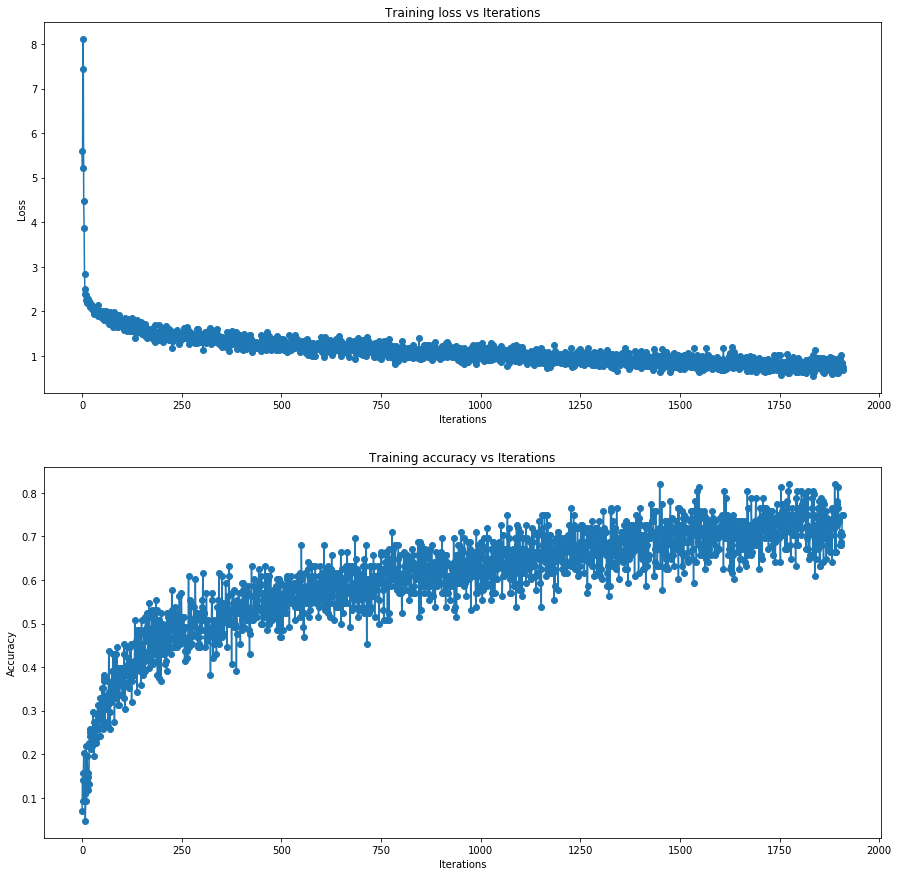

***** test accuracy: 0.617
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [6]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2 [15pt]

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training. For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')` and you can set your desired device number.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Batch normalization
- Dropout
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

The rubrics for this question is:
* 15 points when test accuracy >= 75%
* 10 points when test accuracy >= 70%
* 5 points when test accuracy >= 60%

In [9]:
import time
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 50
    
    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.keep_prob = tf.placeholder(tf.float32)
        self.training = tf.placeholder_with_default(False, shape = None)
        
        
    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        self.step = tf.get_variable(name = 'step', dtype = tf.int32, initializer = 0)
        self.rate = tf.train.exponential_decay(5e-4, self.step, 500, 0.96)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        print(f'self.update_ops: {self.update_ops}')
        with tf.control_dependencies(self.update_ops):
            self.train_op = tf.train.AdamOptimizer(self.rate).minimize(self.loss_op, global_step=self.step)

        self.train_op = tf.train.AdamOptimizer(self.rate).minimize(self.loss_op, global_step=self.step)
#         #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def _loss(self, labels, logits):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels, logits, name='vanilla_loss'))
        l2_regularizer_loss = tf.losses.get_regularization_loss()
        self.reg_loss_op = l2_regularizer_loss
        self.loss_op = loss + l2_regularizer_loss

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        self.zca_epsilon = 1e-6
        self.principal_components = tf.get_variable('principal_comp', [3072, 3072], tf.float32, tf.constant_initializer(0.0), trainable = False)
        print('intput layer: ' + str(self.X.get_shape()))
        
        self.first_flat = flatten(self.X)
        self.whitex_flat = tf.matmul(self.first_flat, self.principal_components)
        self.whitex = tf.reshape(self.whitex_flat, [-1, 32, 32, 3])
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.whitex, 7, 1, 32)
            self.bn1 = tf.layers.batch_normalization(self.conv1, training = self.training)
            self.elu1 = tf.nn.elu(self.bn1)
            self.do1 = tf.nn.dropout(self.elu1, self.keep_prob)
            self.pool1 = max_pool(self.do1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.bn2 = tf.layers.batch_normalization(self.conv2, training = self.training)
            self.elu2 = tf.nn.elu(self.bn2)
            self.do2 = tf.nn.dropout(self.elu2, self.keep_prob)
            self.pool2 = max_pool(self.do2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.bn3 = tf.layers.batch_normalization(self.fc3, training = self.training)
            self.elu3 = tf.nn.elu(self.bn3)
            self.do3 = tf.nn.dropout(self.elu3, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.elu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.do3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def fit_zca(self, x):
        flat_x = np.reshape(
                x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
        u, s, _ = np.linalg.svd(sigma)
        s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
        self.principal_components_value = (u * s_inv).dot(u.T)
    
    def compute_projection(self, x):
        flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
        whitex = np.dot(flatx, self.principal_components)
        x_trans = np.reshape(whitex, x.shape)
        return x_trans
    
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())
        self.fit_zca(X_train)
#         print(f'Principal components value: {self.principal_components_value}')
        sess.run(tf.assign(self.principal_components, self.principal_components_value))
        step = 0
        losses = []
        accuracies = []
        reg_losses = []
        last_time = time.time()
        train_start = last_time
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.keep_prob: 0.5, self.training: True}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op, self.reg_loss_op]

                _, loss, accuracy, reg_loss = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                reg_losses.append(reg_loss)
                if step % self.log_step == 0:
                    now = time.time()
                    print('iteration (%d): loss = %.3f, reg_loss = %.3f, accuracy = %.3f' %
                        (step, loss, reg_loss, accuracy))
                    print(f'Average iteration time is: {(now - last_time)/self.log_step:.3f}')
                    last_time = now
                    print(f'Total time elapsed is {now - train_start:.3f}')
                    
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            start = time.time()
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            end = time.time()
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            print(f'Time taken for evaluation is {end-start}')
        
        train_end_time = time.time()
        print(f'Total training time is {train_end_time - train_start:.3f}')
        
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
        plt.subplot(2,1,1)
        plt.title('Training loss vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.plot(losses, '-o')
        # Graph 2. X: iteration (training step), Y: training accuracy
        
        plt.subplot(2,1,2)
        plt.title('Training accuracy vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.plot(accuracies, '-o')
        
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
#         print(f'the tensor of principal components is: {sess.run(self.principal_components)}')
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.keep_prob: 1.0, self.training: False}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Your model  -----
intput layer: (?, 32, 32, 3)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
self.update_ops: [<tf.Operation 'conv1/batch_normalization/AssignMovingAvg' type=AssignSub>, <tf.Operation 'conv1/batch_norma

validation for epoch 1
-  epoch 1: validation accuracy = 0.492
Time taken for evaluation is 1.0606050491333008
train for epoch 2
iteration (800): loss = 0.922, reg_loss = 0.088, accuracy = 0.695
Average iteration time is: 0.321
Total time elapsed is 242.781
iteration (900): loss = 0.855, reg_loss = 0.089, accuracy = 0.711
Average iteration time is: 0.334
Total time elapsed is 276.176
iteration (1000): loss = 0.763, reg_loss = 0.089, accuracy = 0.750
Average iteration time is: 0.386
Total time elapsed is 314.758
iteration (1100): loss = 0.804, reg_loss = 0.089, accuracy = 0.742
Average iteration time is: 0.690
Total time elapsed is 383.781
validation for epoch 2
-  epoch 2: validation accuracy = 0.585
Time taken for evaluation is 1.8320410251617432
train for epoch 3
iteration (1200): loss = 0.707, reg_loss = 0.090, accuracy = 0.781
Average iteration time is: 0.716
Total time elapsed is 455.364
iteration (1300): loss = 1.050, reg_loss = 0.090, accuracy = 0.648
Average iteration time is: 

validation for epoch 14
-  epoch 14: validation accuracy = 0.766
Time taken for evaluation is 1.1327674388885498
train for epoch 15
iteration (5800): loss = 0.525, reg_loss = 0.098, accuracy = 0.852
Average iteration time is: 0.314
Total time elapsed is 2991.284
iteration (5900): loss = 0.523, reg_loss = 0.098, accuracy = 0.820
Average iteration time is: 0.325
Total time elapsed is 3023.758
iteration (6000): loss = 0.483, reg_loss = 0.098, accuracy = 0.836
Average iteration time is: 0.296
Total time elapsed is 3053.387
iteration (6100): loss = 0.555, reg_loss = 0.098, accuracy = 0.859
Average iteration time is: 0.289
Total time elapsed is 3082.298
validation for epoch 15
-  epoch 15: validation accuracy = 0.759
Time taken for evaluation is 1.0721313953399658
train for epoch 16
iteration (6200): loss = 0.593, reg_loss = 0.098, accuracy = 0.812
Average iteration time is: 0.301
Total time elapsed is 3112.392
iteration (6300): loss = 0.605, reg_loss = 0.098, accuracy = 0.836
Average iterat

iteration (10700): loss = 0.397, reg_loss = 0.094, accuracy = 0.875
Average iteration time is: 0.622
Total time elapsed is 4840.160
iteration (10800): loss = 0.409, reg_loss = 0.094, accuracy = 0.906
Average iteration time is: 0.563
Total time elapsed is 4896.452
iteration (10900): loss = 0.316, reg_loss = 0.094, accuracy = 0.945
Average iteration time is: 0.545
Total time elapsed is 4950.996
iteration (11000): loss = 0.508, reg_loss = 0.094, accuracy = 0.844
Average iteration time is: 0.610
Total time elapsed is 5012.032
validation for epoch 28
-  epoch 28: validation accuracy = 0.766
Time taken for evaluation is 1.8983285427093506
train for epoch 29
iteration (11100): loss = 0.332, reg_loss = 0.094, accuracy = 0.930
Average iteration time is: 0.617
Total time elapsed is 5073.704
iteration (11200): loss = 0.448, reg_loss = 0.094, accuracy = 0.891
Average iteration time is: 0.551
Total time elapsed is 5128.788
iteration (11300): loss = 0.442, reg_loss = 0.094, accuracy = 0.883
Average 

-  epoch 40: validation accuracy = 0.779
Time taken for evaluation is 2.229712724685669
train for epoch 41
iteration (15700): loss = 0.367, reg_loss = 0.088, accuracy = 0.906
Average iteration time is: 0.617
Total time elapsed is 8092.868
iteration (15800): loss = 0.447, reg_loss = 0.088, accuracy = 0.883
Average iteration time is: 0.538
Total time elapsed is 8146.704
iteration (15900): loss = 0.393, reg_loss = 0.088, accuracy = 0.891
Average iteration time is: 0.538
Total time elapsed is 8200.552
iteration (16000): loss = 0.354, reg_loss = 0.088, accuracy = 0.938
Average iteration time is: 0.538
Total time elapsed is 8254.354
validation for epoch 41
-  epoch 41: validation accuracy = 0.775
Time taken for evaluation is 1.9360651969909668
train for epoch 42
iteration (16100): loss = 0.375, reg_loss = 0.088, accuracy = 0.914
Average iteration time is: 0.555
Total time elapsed is 8309.804
iteration (16200): loss = 0.367, reg_loss = 0.088, accuracy = 0.898
Average iteration time is: 0.379


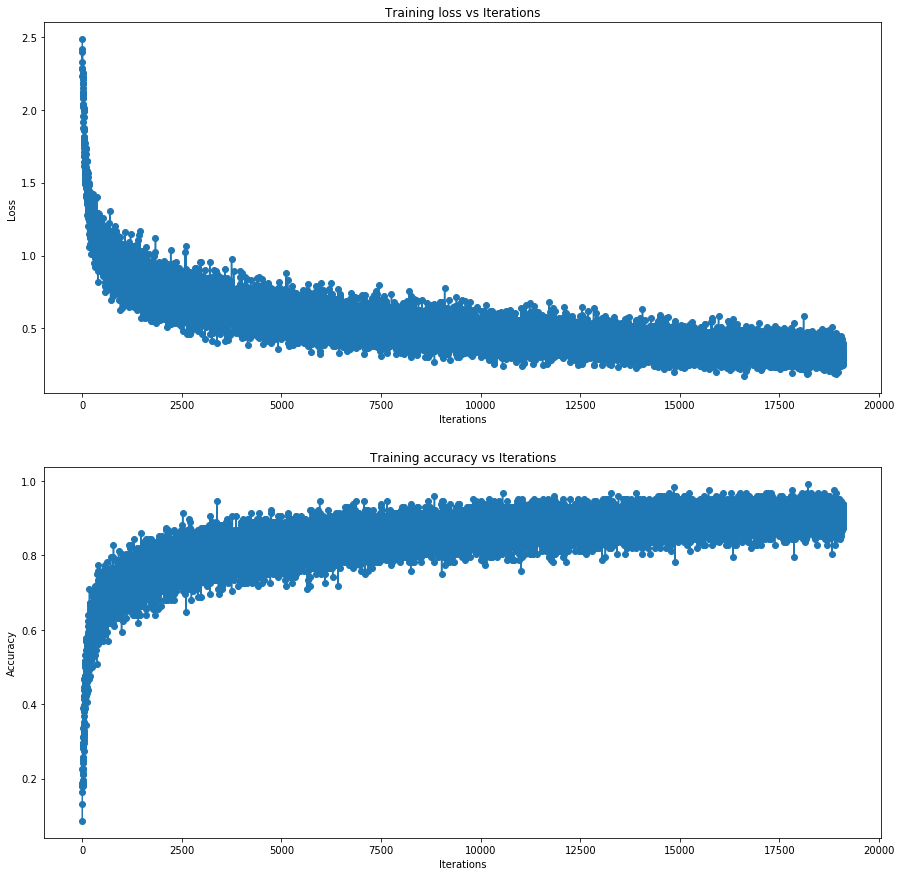

***** test accuracy: 0.772
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [10]:
# Clear old computation graphs
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")